In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
import gc

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 21 01:47:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 16.0 MB/s 


In [4]:
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import pandas as pd
import numpy as np 
from tqdm import tqdm
import cv2
import os
import timm
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
import time
from PIL import Image 

import ttach as tta


## Scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
def to_be_balanced(df) :

  '''
  아이디어는 일단 RAM이 터지면 안 되니까 기존 이미지 수를 class 별로 최대한 유지하면서 이상치"들"과 정상데이터의 비율을 1:1로 최대한 맞추려고 했음
  그 비율이 되게 하는 수를 n이라고 하면.. 정상데이터 중에서 random으로 n개를 고르고
  이상치는 그 n에 맞게 복사시켜서 추가시키는 걸로!

  '''
  ## 새로 쓸 y_train 생성
  balanced_train_y = pd.DataFrame(columns = df.columns)
  class_lst = df['class'].unique()
  ## class 별로 이상치 조정 시작
  for cls in class_lst :
    cls_df = df[df['class']==cls]
    print(f'{cls} class 의 이상치 조정을 시작합니다.')

    ## 적절한 수 유지 계산
    total_ = cls_df.shape[0] 
    num_inner_class = len(cls_df['label'].unique()) 
    good_num =  (total_ // num_inner_class)*2  ## If you multifly integer here, you can get more imgs from data..!! as long as your RAM can indure... 
                                               ## But your time per epoch will be takend longer before..!

    ## good_num과 이상치들의 평균 수의 차이 계산
    avg_lier = np.mean(cls_df['label'].value_counts()[1:].values)  ## 보통 정상치가 제일 많으니까.. [1:]하면 이상치 나오더라구용
    multi_ply = (good_num//avg_lier).astype('int32') 

    g_idx = []
    b_idx = []
    for idx, i  in enumerate(cls_df['label']) :
      
      ## 정상 데이터 추려내기
      if i.endswith('-good') :   ## 정상 데이터라면 
        g_idx.append(idx)        ## 그 인덱스 list에 추가하고  
      
      ## 이상치 추려내기
      if not i.endswith('-good') : 
          b_idx.append(idx)


    ## g_idx 중, 랜덤으로 good_num만큼 선택, 선택받은 아이들이 됨
    sel = np.random.choice(g_idx,good_num)

    ## trian_y에서의 index가 뭔지 알아내기
    real_idx = cls_df.iloc[sel,:].index

    lier_real = cls_df.iloc[b_idx,:].index ##Multi_ply 만큼 concat반복해줄 예정
    bad_ = df.iloc[lier_real]

    balanced_train_y = pd.concat([balanced_train_y ,df.iloc[real_idx,:]])
    for i in range(multi_ply) :
      balanced_train_y = pd.concat([balanced_train_y, bad_])

    ## 다 끝나면 메모리 비우기~
    gc.collect()

  print('이상치 조정 끝')

  return balanced_train_y

In [7]:
# ## 여기부터 ZIP FILE 압축 풀기 ##
# %cd /content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re
# !unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/open.zip"

## This code was used for download original zip file

In [8]:
## 파일 불러오기
# Trian Data unzip 
%cd /content
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/train.zip"
print("train file Unzip is Completed!!")

# Define Train Set
train = sorted(glob('/content/train/*.png'))

# Test Data unzip 
%cd /content
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/test.zip"
print("test file Unzip is Completed!!")

# Define Test Set
test = sorted(glob('/content/test/*.png'))

/content
train file Unzip is Completed!!
/content
test file Unzip is Completed!!


In [9]:
train_y = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/train_df.csv")
train_y = train_y.iloc[:,1:]

In [10]:
balanced_train_y = to_be_balanced(train_y)
balanced_train_y =  balanced_train_y.reset_index(drop=True)

transistor class 의 이상치 조정을 시작합니다.
capsule class 의 이상치 조정을 시작합니다.
wood class 의 이상치 조정을 시작합니다.
bottle class 의 이상치 조정을 시작합니다.
screw class 의 이상치 조정을 시작합니다.
cable class 의 이상치 조정을 시작합니다.
carpet class 의 이상치 조정을 시작합니다.
hazelnut class 의 이상치 조정을 시작합니다.
pill class 의 이상치 조정을 시작합니다.
metal_nut class 의 이상치 조정을 시작합니다.
zipper class 의 이상치 조정을 시작합니다.
leather class 의 이상치 조정을 시작합니다.
toothbrush class 의 이상치 조정을 시작합니다.
tile class 의 이상치 조정을 시작합니다.
grid class 의 이상치 조정을 시작합니다.
이상치 조정 끝


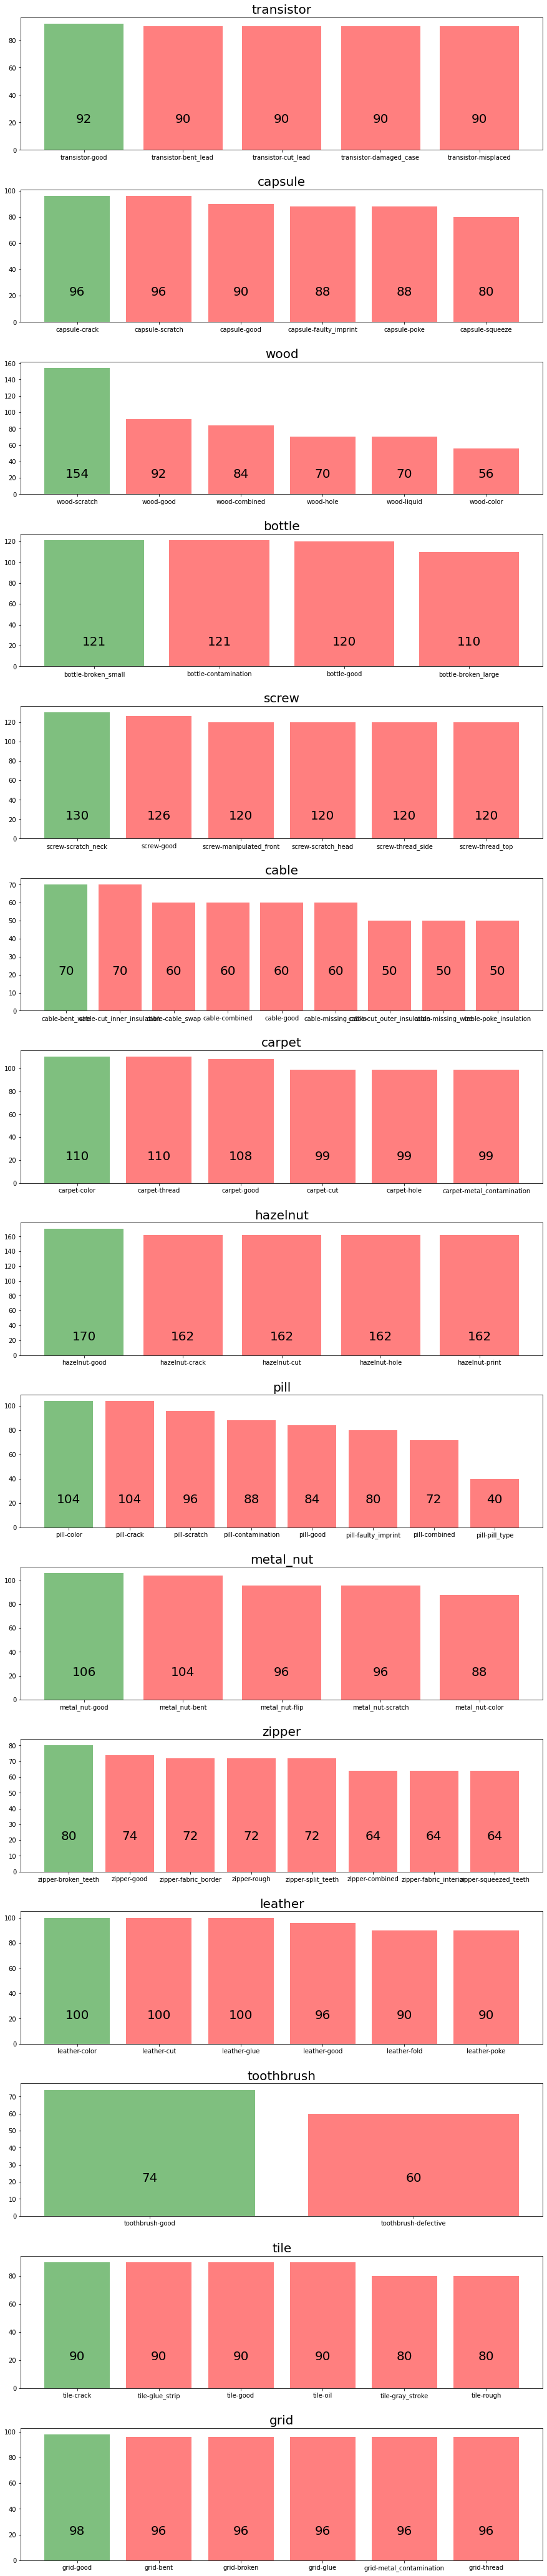

In [11]:
## 시각화

classList = balanced_train_y['class'].unique()
labelList = balanced_train_y['label'].unique()
labelCount = balanced_train_y[['class', 'label']].groupby('label').count().rename(columns={'class': 'count'})
anomaly_dict = {}
for className in classList:
    df = pd.DataFrame(labelCount[labelCount.index.str.contains(className)]).sort_values(by='count', ascending=False)
    anomaly_dict[className] = df
fig, axs = plt.subplots(15, 1, figsize=(15, 15*5))
fig.subplots_adjust(hspace = .3)
axs = axs.ravel()

for i, (className, df) in enumerate(anomaly_dict.items()):
    colors = ['red' for i in range(len(df.index))]
    colors[0] = 'green'
    axs[i].bar(df.index, df.iloc[:, 0], color=colors, alpha=0.5)
    axs[i].set_title(className, fontsize=20)
    for j, value in enumerate(df.iloc[:, 0]):
        axs[i].text(j, 20, df.iloc[:, 0][j], ha='center', fontsize=20)

# CONFIG

In [40]:
img_size = 300 ## Recommended Resolution for EFN V2 B3

model_name_1 = 'V1_FIN_more_aug_x2_SoMANYensemble.pt'
model_name_2 = 'V2_FIN_more_aug_x2_SoMANYensemble.pt'


sub_name = "FIN_Idk_anymore__!!!!!!!.csv"


seed = 42
os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


batch = 32
epochs = 10


# AUGMENTATION

In [27]:
import torchvision
import torchvision.transforms as transforms

## add AUGMENTATION.. 
## our augmentation strategy depend on the randomness of transforms 
## So I think It will be better to add more random augmentation

train_transform = transforms.Compose([
        transforms.Resize((img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(), ## added
        transforms.RandomRotation(0.5, expand=False),
        transforms.RandomResizedCrop(size = (img_size), scale = (0.7, 1)), ## added
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1), ## added
        transforms.RandomAffine((-20,20)), ## added
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.433038, 0.403458, 0.394151],
        std = [0.181572, 0.174035, 0.163234]),                   
])


test_transform = transforms.Compose([
        transforms.Resize((img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.418256, 0.393101, 0.386632],
        std = [0.195055, 0.190053, 0.185323])
])

In [28]:
test = sorted(glob('/content/test/*.png'))

In [29]:
train_list = []
for i in balanced_train_y['file_name']:
  train_list.append("/content/train/{}".format(i))

In [30]:
train_labels = balanced_train_y["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

train_labels = [label_unique[k] for k in train_labels]

# DATASET CLASS

In [31]:
class Custom_dataset(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode = mode
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx] ## Allocating Path 
        img = Image.open(img_path).convert('RGB') 
        # if img.size()[0] ==1 :
        #   img = torch.stack((img,img,img)).squeeze()
        if self.mode=='train':               
            img = train_transform(img) 

               
        if self.mode=='test':
          img = test_transform(img)


        label = self.labels[idx]
        return img, label

class Network_V2(nn.Module):
    def __init__(self):
        super(Network_V2, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_b3', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x


class Network_V1(nn.Module):
    def __init__(self):
        super(Network_V1, self).__init__()
        self.model = timm.create_model('efficientnet_b3', pretrained=True, num_classes=88)
        
    def forward(self, x):
        x = self.model(x)
        return x

# DATA LOADER

In [32]:

# Train
train_dataset = Custom_dataset(np.array(train_list), np.array(train_labels), mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch)
del train_list

In [33]:
# Test
test_dataset = Custom_dataset(np.array(test), np.array(["tmp"]*len(test)), mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch)
del test

# SCORE FUNCTION

In [34]:
def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

In [35]:
torch.cuda.empty_cache()

In [36]:
device = torch.device('cuda')

In [23]:
net_1 = Network_V1().to("cuda") 
net_2 = Network_V2().to("cuda")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-effv2-weights/tf_efficientnetv2_b3-57773f13.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnetv2_b3-57773f13.pth


# Train

In [41]:
### Training V2 B3

model_v2 = Network_V2().to(device) 

## for 3rd TRAINING (continued from 10epoch... our goal is 10 more epochs, total 30epochs (20+10))
# ~10Epoch : just training
# ~20Epoch : more datas (x2) training
# ~30Epoch : more Random Augmentation Training (ofcourse x2)
model_v2.load_state_dict(torch.load(f'/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/SAVING MODEL/_V2B3_20epo_cnvtRGB_adamW_norm_pro.pt')) ## load trained V2B3 model


optimizer = torch.optim.AdamW(model_v2.parameters(), lr=1e-4, weight_decay = 1e-3 )
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 
# scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0 = 5, T_mult = 1, eta_min = 1e-5)

## For Saving Best MODEL
highest_f1 = 0

best=0
print("Start Training...")
for epo_num,epoch in enumerate(range(epochs)):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model_v2.train()
    for batch in (train_loader):
        gc.collect()
        torch.cuda.empty_cache()
        
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model_v2(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
    
    # scheduler.step()    ## lr_scheduler step
    # print('!! LR_SCHEDULER is Worked !!')
    
    train_f1 = score_function(train_y, train_pred)


    if train_f1 > highest_f1:
      highest_f1 = train_f1
      

      torch.save(model_v2.state_dict(), f"/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/FIN SAVING MODEL/{model_name_2} + {epo_num}") ## added epo_num because I think we need more ensemble model..
      print('!! Best Trained Model is Saved !!')



    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

Start Training...
!! Best Trained Model is Saved !!
epoch : 1/10    time : 534s/4810s
TRAIN    loss : 0.09396    f1 : 0.97672
!! Best Trained Model is Saved !!
epoch : 2/10    time : 531s/4251s
TRAIN    loss : 0.07103    f1 : 0.98284
!! Best Trained Model is Saved !!
epoch : 3/10    time : 519s/3634s
TRAIN    loss : 0.06829    f1 : 0.98390
!! Best Trained Model is Saved !!
epoch : 4/10    time : 525s/3150s
TRAIN    loss : 0.05850    f1 : 0.98811
!! Best Trained Model is Saved !!
epoch : 5/10    time : 529s/2645s
TRAIN    loss : 0.05459    f1 : 0.98933
epoch : 6/10    time : 527s/2109s
TRAIN    loss : 0.05867    f1 : 0.98713
epoch : 7/10    time : 517s/1552s
TRAIN    loss : 0.06129    f1 : 0.98683
!! Best Trained Model is Saved !!
epoch : 8/10    time : 521s/1041s
TRAIN    loss : 0.04090    f1 : 0.99214
epoch : 9/10    time : 529s/529s
TRAIN    loss : 0.05028    f1 : 0.98867
!! Best Trained Model is Saved !!
epoch : 10/10    time : 528s/0s
TRAIN    loss : 0.04326    f1 : 0.99319


In [42]:
### Training V1 
model_v1 = Network_V1().to(device)




## for 3rd TRAINING (continued from 10epoch... our goal is 10 more epochs, total 30epochs (20+10))
# ~10Epoch : just training
# ~20Epoch : more datas (x2) training
# ~30Epoch : more Random Augmentation Training (ofcourse x2)
model_v1.load_state_dict(torch.load(f'/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/SAVING MODEL/_V1B3_20epo_cnvtRGB_adamW_norm_pro.pt')) ## load trained V1B3 model 



optimizer = torch.optim.AdamW(model_v1.parameters(), lr=1e-4, weight_decay = 1e-3 )
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 
# scheduler = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0 = 5, T_mult = 1, eta_min = 1e-5)

## For Saving Best MODEL
highest_f1 = 0

best=0
print("Start Training...")
for epo_num,epoch in enumerate(range(epochs)):
    start=time.time()
    train_loss = 0
    train_pred=[]
    train_y=[]
    model_v1.train()
    for batch in (train_loader):
        gc.collect()
        torch.cuda.empty_cache()
        
        optimizer.zero_grad()
        x = torch.tensor(batch[0], dtype=torch.float32, device=device)
        y = torch.tensor(batch[1], dtype=torch.long, device=device)
        with torch.cuda.amp.autocast():
            pred = model_v1(x)
        loss = criterion(pred, y)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        train_loss += loss.item()/len(train_loader)
        train_pred += pred.argmax(1).detach().cpu().numpy().tolist()
        train_y += y.detach().cpu().numpy().tolist()
    
    # scheduler.step()    ## lr_scheduler step
    # print('!! LR_SCHEDULER is Worked !!')
    
    train_f1 = score_function(train_y, train_pred)


    if train_f1 > highest_f1:
      highest_f1 = train_f1
      

      torch.save(model_v1.state_dict(), f"/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/FIN SAVING MODEL/{model_name_1} + {epo_num}")
      print('!! Best Trained Model is Saved !!')



    TIME = time.time() - start
    print(f'epoch : {epoch+1}/{epochs}    time : {TIME:.0f}s/{TIME*(epochs-epoch-1):.0f}s')
    print(f'TRAIN    loss : {train_loss:.5f}    f1 : {train_f1:.5f}')

Start Training...
!! Best Trained Model is Saved !!
epoch : 1/10    time : 562s/5061s
TRAIN    loss : 0.08240    f1 : 0.98039
!! Best Trained Model is Saved !!
epoch : 2/10    time : 569s/4552s
TRAIN    loss : 0.06430    f1 : 0.98519
!! Best Trained Model is Saved !!
epoch : 3/10    time : 574s/4017s
TRAIN    loss : 0.05702    f1 : 0.98796
epoch : 4/10    time : 577s/3459s
TRAIN    loss : 0.06011    f1 : 0.98712
!! Best Trained Model is Saved !!
epoch : 5/10    time : 574s/2868s
TRAIN    loss : 0.05565    f1 : 0.99005
epoch : 6/10    time : 569s/2275s
TRAIN    loss : 0.05205    f1 : 0.99000
!! Best Trained Model is Saved !!
epoch : 7/10    time : 565s/1696s
TRAIN    loss : 0.05082    f1 : 0.99032
!! Best Trained Model is Saved !!
epoch : 8/10    time : 571s/1142s
TRAIN    loss : 0.04464    f1 : 0.99159
!! Best Trained Model is Saved !!
epoch : 9/10    time : 573s/573s
TRAIN    loss : 0.03947    f1 : 0.99487
!! Best Trained Model is Saved !!
epoch : 10/10    time : 570s/0s
TRAIN    loss

# Ensemble Inference with TTA

In [62]:
def load_models(models, ver=None) :
    for model in models :
        if ver == 1 :
            model = Network_V1.to(device)
            model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/FIN SAVING MODEL/{trained_model}'))
            tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)

            return tta_model

        if ver == 2 :
            model = Network_V2.to(device)
            model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/FIN SAVING MODEL/{trained_model}'))
            tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)

            return tta_model

In [64]:
## tta_transforms
tta_transforms = tta.Compose(
    [tta.HorizontalFlip(),
    tta.VerticalFlip(),
    tta.Rotate90(angles=[0, 90, 180, 270]),
    tta.Rotate90(angles=[0, 90, 180, 270]),
    tta.Multiply([0.9, 1])
    ]
)

V1_models = [
    "V1_FIN_more_aug_x2_SoMANYensemble.pt + 9",
    "V1_FIN_more_aug_x2_SoMANYensemble.pt + 8",
    "V1_FIN_more_aug_x2_SoMANYensemble.pt + 7",
    "V1_FIN_more_aug_x2_SoMANYensemble.pt + 6",
    "V1_FIN_more_aug_x2_SoMANYensemble.pt + 4",
]

V2_models = [
    "V2_FIN_more_aug_x2_SoMANYensemble.pt + 9",
    "V2_FIN_more_aug_x2_SoMANYensemble.pt + 7",
    "V2_FIN_more_aug_x2_SoMANYensemble.pt + 4",
    "V2_FIN_more_aug_x2_SoMANYensemble.pt + 3",
    "V2_FIN_more_aug_x2_SoMANYensemble.pt + 2",
]

load_models(V1_models, ver=1)
load_models(V2_models, ver=2)

In [57]:
tta_model_v1_9.eval()
tta_model_v1_8.eval()
tta_model_v1_7.eval()
tta_model_v1_6.eval()
tta_model_v1_4.eval()

tta_model_v2_9.eval()
tta_model_v2_7.eval()
tta_model_v2_4.eval()
tta_model_v2_3.eval()
tta_model_v2_2.eval()

tta_pred = []

print("Start the Inference")

with torch.no_grad():
    print("Making Ensemble Prediction...")
    for batch in (test_loader):
        x = torch.tensor(batch[0], dtype = torch.float32, device = device)
        with torch.cuda.amp.autocast():
            
            pred_1 = tta_model_v1_9(x)
            pred_2 = tta_model_v1_8(x)
            pred_3 = tta_model_v1_7(x)
            pred_4 = tta_model_v1_6(x)
            pred_5 = tta_model_v1_4(x)
            pred_6 = tta_model_v2_9(x)
            pred_7 = tta_model_v2_7(x)
            pred_8 = tta_model_v2_4(x)
            pred_9 = tta_model_v2_3(x)
            pred_10 = tta_model_v2_2(x)

            pred = (pred_1 + pred_2 + pred_3 + pred_4 + pred_5 +
                     pred_6 + pred_7 + pred_8 + pred_9 + pred_10 )/10

        
        tta_pred.extend(pred.argmax(1).detach().cpu().numpy().tolist())
    print("Done")

label_decoder = {val:key for key, val in label_unique.items()}
f_result = [label_decoder[result] for result in tta_pred]

print("Finish the Inference")

Start the Inference
Making Ensemble Prediction...
Done
Finish the Inference


# Submission

In [58]:
submission = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/sample_submission.csv")

submission["label"] = f_result

submission

,index,label
0,0,tile-glue_strip
1,1,grid-good
2,2,transistor-good
3,3,tile-gray_stroke
4,4,tile-good
...,...,...
2149,2149,tile-gray_stroke
2150,2150,screw-good
2151,2151,grid-good
2152,2152,cable-good


In [59]:
submission.to_csv(f"/content/gdrive/MyDrive/Colab Notebooks/ANOMAL_re/SAVING SUBMISSION/{sub_name}", index = False)